# Comparing Two Models on a Reaction Channel

This is a personal notebook used to generate a figure for a journal article. It compares two ML models performance on the Cl-35(N,P)S-35 reaction channel.

In [1]:
# # Prototype
# import sys
# sys.path.append("..")

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
import nucml.exfor.data_utilities as exfor_utils
import nucml.datasets as nuc_data
import nucml.ace.data_utilities as ace_utils
import nucml.model.utilities as model_utils

In [6]:
figure_dir = "Figures/"

In [51]:
sns.set(font_scale=2.5)
sns.set_style('white')

## Loading Data

Since I am comparing two models using Dataset 0 and 2, I need to load them for inference.

In [8]:
df_b0, _, _, _, _, to_scale_b0, _ = nuc_data.load_exfor(pedro=True, basic=0, normalize=False)
df_b2, _, _, _, _, to_scale_b2, _ = nuc_data.load_exfor(pedro=True, basic=2)

INFO:root: MODE: neutrons
INFO:root: LOW ENERGY: True
INFO:root: LOG: True
INFO:root: BASIC: 0
INFO:root:Reading data from C:/Users/Pedro/Desktop/ML_Nuclear_Data/EXFOR/CSV_Files\EXFOR_neutrons/EXFOR_neutrons_MF3_AME_no_RawNaN.csv
INFO:root:Data read into dataframe with shape: (4322622, 8)
INFO:root:Splitting dataset into training and testing...
INFO:root:Normalizing dataset...
INFO:root:Fitting new scaler.
INFO:root: MODE: neutrons
INFO:root: LOW ENERGY: True
INFO:root: LOG: True
INFO:root: BASIC: 2
INFO:root:Reading data from C:/Users/Pedro/Desktop/ML_Nuclear_Data/EXFOR/CSV_Files\EXFOR_neutrons/EXFOR_neutrons_MF3_AME_no_RawNaN.csv
INFO:root:Data read into dataframe with shape: (4322622, 18)
INFO:root:Splitting dataset into training and testing...
INFO:root:Normalizing dataset...
INFO:root:Fitting new scaler.


We also need to load the evaluation and the ace energy grid. The grid allows the model to predict cross sections at those energy points and can consequently calculate errors that might be of interest for reporting.

In [9]:
endf_cl = nuc_data.load_evaluation("Cl035", 103, log=True)

INFO:root:EVALUATION: Extracting data from C:/Users/Pedro/Desktop/ML_Nuclear_Data/Evaluated_Data\neutrons/Cl035/endfb8.0/tables/xs/n-Cl035-MT103.endfb8.0
INFO:root:EVALUATION: Converting MeV to eV...
INFO:root:EVALUATION: Converting mb to b...
INFO:root:EVALUATION: Finished. ENDF data contains 8791 datapoints.


In [10]:
ace_cl = ace_utils.get_energies("17035", ev=True, log=True)

## Extracting and Importing the Best ML Models

Having already trained a variety of algorithms, we can extract and import the best model in terms of training, validation, and testing. 

**NOTE: For the `get_best_models_df()` to work, your csv/dataframe file must contain a train_mae, test_mae, and val_mae columns.**

In [11]:
knn_results = pd.read_csv("1_KNN/knn_results_B2.csv").sort_values(by="id")
best_knn = model_utils.get_best_models_df(knn_results, keep_first=True)
best_knn

,id,distance_metric,mt_strategy,normalizer,train_mae,train_mse,train_evs,train_mae_m,train_r2,val_mae,...,test_mae,test_mse,test_evs,test_mae_m,test_r2,model_path,training_time,scaler_path,run_name,tag
19,20,manhattan,one_hot,minmax,0.025820,0.010877,0.985897,0.0,0.985897,0.117205,...,0.116502,0.059456,0.919866,0.042790,0.919864,E:\ML_Models_EXFOR\KNN_B2\k20_distance_manhatt...,11610.134845,E:\ML_Models_EXFOR\KNN_B2\k20_distance_manhatt...,k20_distance_manhattan_minmax_one_hot_B2_v1,Train
8,11,manhattan,one_hot,minmax,0.025873,0.010936,0.985819,0.0,0.985819,0.115434,...,0.115954,0.061345,0.918705,0.040778,0.918705,E:\ML_Models_EXFOR\KNN_B2\k11_distance_manhatt...,9453.814605,E:\ML_Models_EXFOR\KNN_B2\k11_distance_manhatt...,k11_distance_manhattan_minmax_one_hot_B2_v1,Val
0,13,manhattan,one_hot,minmax,0.025877,0.010921,0.985853,0.0,0.985853,0.116044,...,0.115255,0.060093,0.919002,0.041119,0.919002,E:\ML_Models_EXFOR\KNN_B2\k13_distance_manhatt...,6122.514390,E:\ML_Models_EXFOR\KNN_B2\k13_distance_manhatt...,k13_distance_manhattan_minmax_one_hot_B2_v1,Test


In [12]:
knn_train_model, knn_train_scaler = model_utils.load_model_and_scaler(best_knn.iloc[[0]])

In [13]:
dt_results = pd.read_csv("2_DT/dt_resultsB0.csv").sort_values(by="max_depth")
dt_results = dt_results[dt_results.normalizer == "none"]
best_dt = model_utils.get_best_models_df(dt_results, keep_first=True)
best_dt

,id,max_depth,mss,msl,mt_strategy,normalizer,train_mae,train_mse,train_evs,train_mae_m,...,val_r2,test_mae,test_mse,test_evs,test_mae_m,test_r2,model_path,training_time,scaler_path,tag
369,681,400,2,1,one_hot,none,0.025773,0.010789,0.985999,0.000000,...,0.894051,0.135027,0.081226,0.895526,0.047396,0.895523,E:\ML_Models_EXFOR\DT_B0\DT400_MSS2_MSL1_none_...,109.273998,E:\ML_Models_EXFOR\DT_B0\DT400_MSS2_MSL1_none_...,Train
376,494,84,10,7,one_hot,none,0.094411,0.037966,0.948927,0.035953,...,0.923212,0.119076,0.057716,0.922230,0.046595,0.922230,E:\ML_Models_EXFOR\DT_B0\DT84_MSS10_MSL7_none_...,37.965002,E:\ML_Models_EXFOR\DT_B0\DT84_MSS10_MSL7_none_...,Val
99,74,90,10,7,one_hot,none,0.094439,0.038053,0.948807,0.035948,...,0.921833,0.118706,0.057551,0.922877,0.046615,0.922877,E:\ML_Models_EXFOR\DT_B0\DT90_MSS10_MSL7_none_...,34.589237,E:\ML_Models_EXFOR\DT_B0\DT90_MSS10_MSL7_none_...,Test


In [14]:
dt_train_model = model_utils.load_model_and_scaler(best_dt.iloc[[0]], model_only=True)

Additionally, we want to add the newly measured datapoints so we will extract them and process them using the appropiate datasets and scalers.

In [15]:
new_cl_data_kwargs = {"Z":17, "A":35, "MT":103, "log":True, "scale":True, "one_hot":True}
new_cl_data_knn = exfor_utils.load_newdata("../EXFOR/New_Data/cl35_np.csv", df_b2, 
                                          scaler=knn_train_scaler, to_scale=to_scale_b2, **new_cl_data_kwargs)

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (227, 50)
INFO:root:Scaling dataset...
INFO:root:EXFOR extracted DataFrame has shape: (12, 50)


In [16]:
new_cl_data_kwargs = {"Z":17, "A":35, "MT":103, "log":True, "scale":False, "one_hot":True}
new_cl_data_dt = exfor_utils.load_newdata("../EXFOR/New_Data/cl35_np.csv", df_b0, **new_cl_data_kwargs)

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (227, 40)
INFO:root:EXFOR extracted DataFrame has shape: (12, 40)


## Plotting Model Predictions

In [68]:
def make_chlorine_paper_figure(df_knn, df_dt, dt_model, knn_model, knn_scaler, to_scale, endf_cl, e_array, saving_dir=None):
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(30,20))

    dt_kwargs = {"nat_iso": "I", "one_hot": True, "scale": False, "to_scale": None}
    knn_kwargs = {"nat_iso": "I", "one_hot": True, "scale": True, "to_scale": to_scale}
    chlorine_data_dt = exfor_utils.load_samples(df_dt, 17, 35, 103, scaler=None, **dt_kwargs)
    chlorine_data_knn = exfor_utils.load_samples(df_knn, 17, 35, 103, scaler=knn_scaler, **knn_kwargs)
    
    new_cl_knn_data_kwargs = {"Z":17, "A":35, "MT":103, "log":True, "scale":True, "one_hot":True}
    new_cl_dt_data_kwargs = {"Z":17, "A":35, "MT":103, "log":True, "scale":False, "one_hot":True}
    
    new_data_knn = exfor_utils.load_newdata(
        "../EXFOR/New_Data/cl35_np.csv", df_knn, scaler=knn_scaler, to_scale=to_scale, **new_cl_knn_data_kwargs)
    
    new_data_dt = exfor_utils.load_newdata(
        "../EXFOR/New_Data/cl35_np.csv", df_dt, scaler=None, **new_cl_dt_data_kwargs)
    
    chlorine_data_ext = exfor_utils.expanding_dataset_energy(chlorine_data_dt, 0, 0, False, 0, e_array=e_array)
    chlorine_data_ext = chlorine_data_ext[chlorine_data_ext.Energy > chlorine_data_dt.Energy.min()]
    
    ax1.plot(10**(chlorine_data_ext.Energy), 10**(dt_model.predict(chlorine_data_ext.drop(columns=["Data"]))), label="DT", linestyle="dashed", c="firebrick", linewidth=3)
    ax1.scatter(10**(chlorine_data_dt.Energy), 10**(chlorine_data_dt.Data), alpha=1.0, c='#1f77b4', label="EXFOR", s=30)
    ax1.scatter(10**(new_data_dt.Energy), 10**(new_data_dt.Data), alpha=1, c='#ff7f0e', s=250, marker="x", label="J.C.Batchelder (2019)")
    ax1.plot(10**(endf_cl.Energy), 10**(endf_cl.Data), alpha=0.8, c="darkgreen", label="ENDF")
    ax1.legend(loc=3)

    chlorine_data_ext = exfor_utils.expanding_dataset_energy(chlorine_data_knn, 0, 0, False, 0, e_array=e_array)
    chlorine_data_ext = chlorine_data_ext[chlorine_data_ext.Energy > chlorine_data_knn.Energy.min()]
    
    ax2.plot(10**(chlorine_data_ext.Energy), 10**(knn_model.predict(chlorine_data_ext.drop(columns=["Data"]))), label="KNN", linestyle="dashed", c="firebrick", linewidth=3)
    ax2.scatter(10**(chlorine_data_knn.Energy), 10**(chlorine_data_knn.Data), alpha=1.0, c='#1f77b4', label="EXFOR", s=30)
    ax2.scatter(10**(new_data_knn.Energy), 10**(new_data_knn.Data), alpha=1, s=250, c='#ff7f0e', marker="x", label="J.C.Batchelder (2019)")
    ax2.plot(10**(endf_cl.Energy), 10**(endf_cl.Data), alpha=0.8, c="darkgreen", label="ENDF")
    ax2.legend(loc=3)

    ax1.set(ylabel='Cross Section (b)')
    ax2.set(ylabel='Cross Section (b)')
    
    ax1.set(xlabel='Energy (eV)') 
    ax2.set(xlabel='Energy (eV)') 
    
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim(10**-2, 10**7.5)
    ax2.set_xlim(10**-2, 10**7.5)
    
    ax1.tick_params(bottom=True, left=True, width=5, direction='out')
    ax2.tick_params(bottom=True, left=True, width=5, direction='out')
    
    plt.savefig(os.path.join(saving_dir, "ML_Cl.png"), dpi=600, bbox_inches="tight")

In [69]:
sns.set(font_scale=3.5)
sns.set_style('white')

INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (227, 40)
INFO:root:Extracting samples from dataframe.
INFO:root:Scaling dataset...
INFO:root:EXFOR extracted DataFrame has shape: (227, 50)
INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (227, 50)
INFO:root:Scaling dataset...
INFO:root:EXFOR extracted DataFrame has shape: (12, 50)
INFO:root:Extracting samples from dataframe.
INFO:root:EXFOR extracted DataFrame has shape: (227, 40)
INFO:root:EXFOR extracted DataFrame has shape: (12, 40)


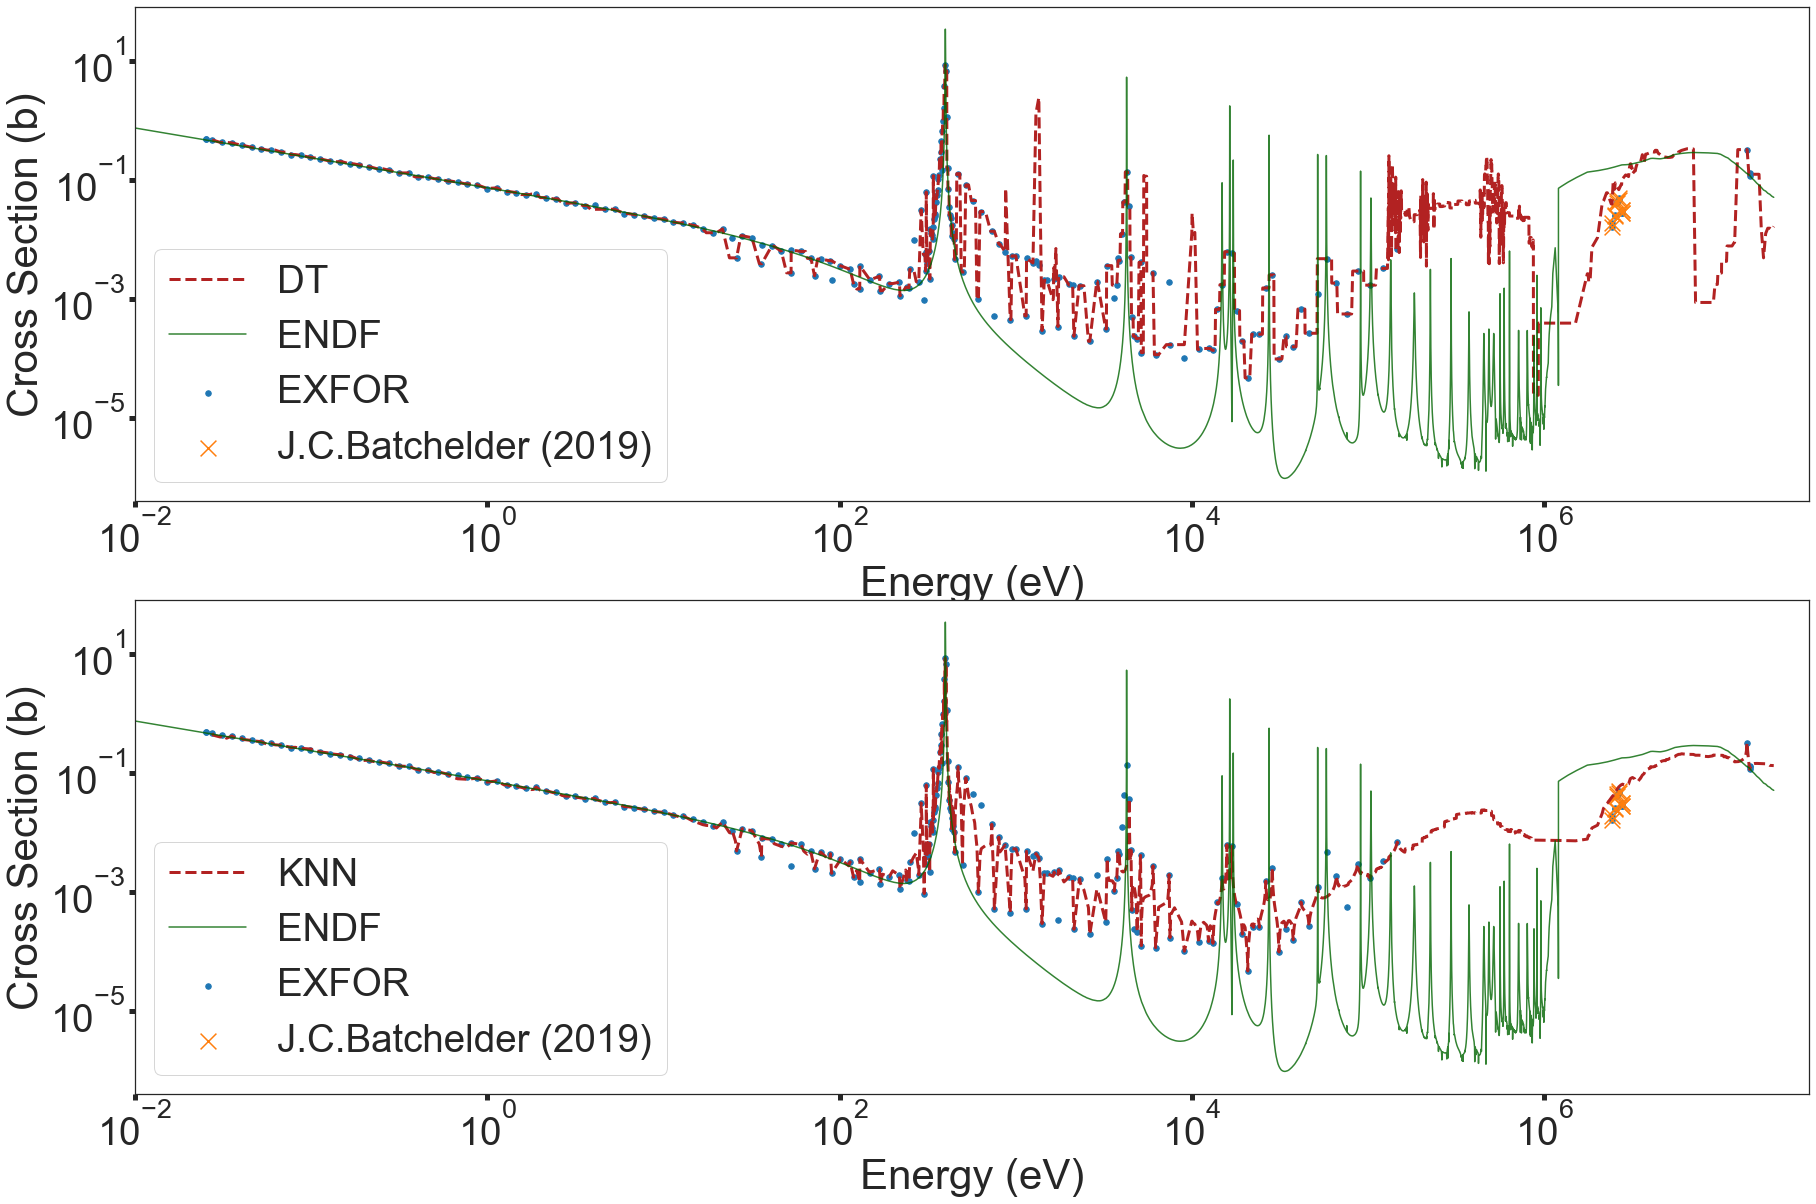

In [70]:
make_chlorine_paper_figure(df_b2, df_b0, dt_train_model, knn_train_model, knn_train_scaler, to_scale_b2, endf_cl, ace_cl, saving_dir=figure_dir)

## Creating an Error Table for Latex

In [43]:
for_latex = pd.DataFrame(columns=["Energy", "Data", "DT", "KNN"])

In [44]:
for_latex["Energy"] = 10**new_cl_data_dt.Energy.values
for_latex["Data"] = 10**new_cl_data_dt.Data.values
for_latex["DT"] = 10**dt_train_model.predict(new_cl_data_dt.drop(columns=["Data"]))
for_latex["KNN"] = 10**knn_train_model.predict(new_cl_data_knn.drop(columns=["Data"]))

In [45]:
print(for_latex.to_latex(index=False))

\begin{tabular}{rrrr}
\toprule
   Energy &   Data &       DT &      KNN \\
\midrule
2420000.0 & 0.0166 & 0.040300 & 0.040723 \\
2420000.0 & 0.0196 & 0.040300 & 0.040723 \\
2520000.0 & 0.0261 & 0.091000 & 0.045894 \\
2520000.0 & 0.0257 & 0.091000 & 0.045894 \\
2580000.0 & 0.0446 & 0.078307 & 0.054121 \\
2580000.0 & 0.0417 & 0.078307 & 0.054121 \\
2640000.0 & 0.0500 & 0.070000 & 0.059396 \\
2640000.0 & 0.0478 & 0.070000 & 0.059396 \\
2740000.0 & 0.0284 & 0.085276 & 0.064900 \\
2740000.0 & 0.0281 & 0.085276 & 0.064900 \\
2740000.0 & 0.0315 & 0.085276 & 0.064900 \\
2740000.0 & 0.0324 & 0.085276 & 0.064900 \\
\bottomrule
\end{tabular}



In [46]:
# Getting the mean
for_latex[["DT", "KNN"]].drop_duplicates().mean()

DT     0.072977
KNN    0.053007
dtype: float64

## NucML Structure Sankey Diagram 

Ignore code below.

In [14]:
import plotly

import plotly.graph_objects as go

# Nodes & links
nodes = [
    ['ID', 'Label', 'Color'],
    [0,'Experiment','#6eab38'],
    [1,'Compilation','#a9a9a9'],
    [2,'Evaluation','#cca5b7'],
    [3,'Processing','#faae82'],
    [4,'Validation','#1db0de'],
    [5,'Application','#989dd4'],
    
    [6, 'nucml.ace','#4C4231'],
    [7, 'nucml.ame','#4C4231'],
    [8, 'nucml.ensdf','#4C4231'],
    [9, 'nucml.evaluation','#4C4231'],
    [10, 'nucml.exfor','#4C4231'],
    [11, 'nucml.model','#4C4231'],
    [12, 'nucml.plot','#4C4231'],
    [13, 'nucml.datasets','#4C4231']
]

values = np.linspace(6,1,6).astype(int)
links = [['Source','Target','Value','Link Color'],

        # Experiment
        [0,8,values[0],'rgba(127, 194, 65, 0.2)'],
        [0,10,values[0],'rgba(127, 194, 65, 0.2)'],

        # Compilation
        [1,7,values[1],'rgba(211, 211, 211, 0.5)'],
        [1,8,values[1],'rgba(211, 211, 211, 0.5)'],
        [1,10,values[1],'rgba(211, 211, 211, 0.5)'],

        # Evaluation
        [2,11,values[2],'#FFD6E9'],
        [2,13,values[2],'#FFD6E9'],

        # Processing
        [3,6,values[3],'rgba(253, 227, 212, 1)'],
        [3,10,values[3],'rgba(253, 227, 212, 1)'],
        
        # Validation
        [4,6,values[4],'#9de4fa'],
        [4,10,values[4],'#9de4fa'],
        [4,11,values[4],'#9de4fa'],
        
        # Application
        [5,6,values[5],'#D6D9F9'],        
        ]

# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
links_headers = links.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)
df_links = pd.DataFrame(links, columns = links_headers)

# Sankey plot setup
data_trace = dict(
    type='sankey',
    arrangement="snap",
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Color']
    ),
    link = dict(
      source = df_links['Source'].dropna(axis=0, how='any'),
      target = df_links['Target'].dropna(axis=0, how='any'),
      value = df_links['Value'].dropna(axis=0, how='any'),
      color = df_links['Link Color'].dropna(axis=0, how='any'),
  )
)

layout = dict(
    title = "Draw Sankey Diagram from dataframes",
    height = 800,
    width = 1400,
    font = dict(size = 20)
)

fig = dict(data=[data_trace], layout=layout)
# iplot(fig, validate=False)
plotly.io.write_image(fig, "Figures/nucml_structure.png", scale=5)


# import plotly.io as pio
# pio.renderers.default = 'browser'

# figure = go.Figure(fig)

# figure